# This notebook reads MOD data from pickle files and displays with cartopy

## Spatial data from rSIR and GRD are displayed using cartopy, with elevation data.


## Load in all the modules needed

No longer requires Basemap, now using cartopy for projection information, and shapely for basin outlines.

In [1]:
%pylab notebook
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from osgeo import gdal, gdal_array  ## to read geotiff array as numpy
from gdalconst import GA_ReadOnly  ## to get other metadata from the geotiff
import shapely.geometry as sgeom
import glob
import matplotlib.pyplot as plt
from netCDF4 import Dataset, num2date
import numpy as np
import os
import pandas as pd
from cetbtools.ease2conv import Ease2Transform
from mpl_toolkits.basemap import Basemap
from pathlib import Path
import time

Populating the interactive namespace from numpy and matplotlib


In [2]:
pd.set_option('display.max_rows', 999)
pd.set_option('display.min_rows', 200)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 120)
pd.set_option('display.max_colwidth', 10)

In [3]:
# Define the local machine location of CETB data cubes
# This directory is expected to contain subdirectories in the following hierarchy
# that duplicates the hierarchy on the Google Shared Drive NSIDC-SD-CETB/v1/, 
# for example:
# dataDir/F13_SSMI/N/nc_cubes/cubes_<regionName>
user = 'Mariah' #Mariah #MJWindows
if ('Joan' == user):
    dataDir = '/mnt/data3/cetb/nsidc0630_v1/' #jmr machine fringe 
    scriptDir = '/mnt/data3/cetb/ipynb_melt_onset/scripts'
    GISDir = ''
elif ('Mariah' == user):
    dataDir = Path(Path.home(), 'nsidc0630_v1') # Mariah's PC or Mary Jo's Mac
    scriptDir = Path(Path.home(), 'ipynb_melt_onset', 'scripts')
    GISDir = Path(Path.home(), 'GIS_data')
elif ('MJWindows' == user):
    dataDir = Path('Z:/mj On My Mac/nsidc0630_v1') # Mary Jo's Windows machine
    scriptDir = Path(Path.home(), 'ipynb_melt_onset', 'scripts')
    GISDir = Path(Path.home(), 'GIS_data')
else:
    raise ValueError("unknown user= %s\n" % (user) )
    
%cd $scriptDir
dataDir, user

/Users/mj/ipynb_melt_onset/scripts


(PosixPath('/Users/mj/nsidc0630_v1'), 'Mariah')

In [4]:
# Load CETB package custom functions now

# load the custom functions
from CETB_IO import read_cetb_geotiff
#from CETB_read_functions import coords
#from CETB_read_functions import calc_DAV
#from CETB_read_functions import find_UIB_cube_offset
#from CETB_read_functions import grid_locations_of_UIB
#from CETB_algorithms import DAV_MOD
#from CETB_analysis import MOD_array
#from CETB_analysis import MOD_array_year

## Read some previously created MOD geotiff images

In [5]:
modsDir = "%s/MODs" % dataDir
os.chdir(modsDir)
#gpd = "EASE2_N3.125km"
modFiles = sort(glob.glob("*.tif"))
modFiles

array(['test.bathurst_range.1995.tif', 'test.bathurst_range.1996.tif',
       'test.bathurst_range.1997.tif', 'test.bathurst_range.Avg.tif',
       'test.tif', 'test3scale.tif'], dtype='<U28')

## Info on reading a tif file with GDAL:
https://automating-gis-processes.github.io/2016/Lesson7-read-raster-array.html

from osgeo import gdal
raster = gdal.Open(modFiles[1])
type(raster)

##Get Projection:

raster.GetProjection()

##Get number of band, dimensions of bands

raster.RasterCount, raster.RasterXSize, raster.RasterYSize

##Read the raster band as separate variable

band = raster.GetRasterBand(1)

##Check type of the variable 'band' and the data type of the contents

type(band), gdal.GetDataTypeName(band.DataType)

##Read raster data as numeric array from GDAL Dataset

rasterArray = raster.ReadAsArray()

In [6]:
Years = [1995, 1996, 1997]

In [7]:
modFiles[3]

'test.bathurst_range.Avg.tif'

In [8]:
# Read raster data as numeric array from file
MOD1995 = read_cetb_geotiff(modFiles[0], verbose=True)
MOD1996 = read_cetb_geotiff(modFiles[1], verbose=True)
MOD1997 = read_cetb_geotiff(modFiles[2], verbose=True)
MODAVG = read_cetb_geotiff(modFiles[3], verbose=True)

Read geotiff image/extent from test.bathurst_range.1995.tif
Read geotiff image/extent from test.bathurst_range.1996.tif
Read geotiff image/extent from test.bathurst_range.1997.tif
Read geotiff image/extent from test.bathurst_range.Avg.tif


In [9]:
MOD1995

{'img': array([[128, 128, 128, ..., 129, 128, 128],
        [128, 128, 128, ..., 128, 128, 128],
        [127, 127, 127, ..., 127, 128, 127],
        ...,
        [128, 128, 128, ..., 157, 157, 157],
        [128, 128, 128, ..., 157, 157, 157],
        [128, 128, 128, ..., 157, 157, 157]], dtype=int16),
 'epsg': 'EPSG:6931',
 'extent': {'minX': -3375000.0,
  'maxX': -2550000.0,
  'minY': 725000.0,
  'maxY': 2025000.0}}

In [10]:
type(MOD1995['img']), MOD1995['img'].shape

(numpy.ndarray, (416, 264))

In [11]:
# For later: initialize the cartopy object according to the epsg code

In [12]:
# Use cartopy to be able to geolocate the maps
# Do a quick sanity check check the UL corner of EASE-Grid 2.0 N should be:
# Answer should be lon=-135. lat=-84.634050
geod = ccrs.Geodetic()
e2n = ccrs.LambertAzimuthalEqualArea(central_latitude=90.0)
lon, lat = geod.transform_point(
    x = -9000000.,
    y = 9000000.,
    src_crs=e2n)
print(lon, lat)

-135.0 -84.6340496694687


# To get the pixel (row, col) and (x, y) values closest to a (lat, lon) location

This operation can be done with the cartopy stuff in general cases, but the Ease2Transform object
is custom-built for the EASE2 projections

In [13]:
# To get EASE2_N3.125km pixel closests to Great Slave Lake
lat = 62.
lon = -115.
easegrid = Ease2Transform('EASE2_N3.125km')
row, col = easegrid.geographic_to_grid(lat, lon)
row = int(row + 0.5)
col = int(col + 0.5)
x, y = easegrid.grid_to_map(row, col)
print(lat, lon, row, col, x, y)


62.0 -115.0 2461 1982 -2804687.5 1307812.5


In [14]:
# For UIB cubes, I rotated 90 degrees clockwise, we can do this for our subsets, too
# e2nRotate = ccrs.LambertAzimuthalEqualArea(central_latitude=90.0, central_longitude=90.0)

## Read some shapefiles for overlays

1) Use shapely to read the .shp files.  This works for lonlat shapefiles, 
it doesn't seem to work for projected ones, there must be an option that I'm just missing.


In [15]:
wetlandfile = '%s/wetlands/GLWD-level1/glwd_1.shp' % GISDir
wetlandFeatures = ShapelyFeature(Reader(wetlandfile).geometries(),
                                 ccrs.PlateCarree())

In [ ]:
#UIBBasinfile = '/work/charis/ti_model/basins/basin_outlines/UIB_Khan/UIB_shape_file/Upstream_Tarbela_lonlat.shp'
#UIBReader = shpreader.Reader(UIBBasinfile)
#UIBRecord = next(UIBReader.records())
#UIBRecord, UIBRecord.attributes, UIBRecord.bounds, UIBRecord.geometry

In [ ]:
#e2nRotateUIBBasin = e2nRotate.project_geometry(UIBRecord.geometry)
#e2nRotateUIBBasin

In [16]:
mindoy = np.min([np.min(MODAVG['img']), np.min(MOD1995['img']), 
                 np.min(MOD1996['img']), np.min(MOD1997['img'])])
mindoy

0.0

In [17]:
maxdoy = np.max([np.max(MODAVG['img']), np.max(MOD1995['img']), 
                 np.max(MOD1996['img']), np.max(MOD1997['img'])])
maxdoy

317.0

In [18]:
extent = list((MODAVG['extent']['minX'], MODAVG['extent']['maxX'], 
              MODAVG['extent']['minY'], MODAVG['extent']['maxY']))
extent

[-3375000.0, -2550000.0, 725000.0, 2025000.0]

# This example is just displaying each array in turn, as an image (no geolocation information)

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(6,6))

#mindoy = 50
#maxdoy = 180

label = "SIR Avg MOD (%4d-%4d)" % (Years[0], Years[-1])
im0 = ax[0,0].imshow(MODAVG['img'], cmap='RdBu', interpolation='None', vmin=mindoy, vmax=maxdoy, label=label)
cbar0 = fig.colorbar(im0, ax=ax[0,0])
cbar0.ax.set_ylabel('DOY')
ax[0,0].axis('off')
ax[0,0].set_title(label)

label = "SIR MOD (%s)" % Years[0]
im1 = ax[0,1].imshow(MOD1995['img'], cmap='RdBu', interpolation='None', vmin=mindoy, vmax=maxdoy, label=label)
fig.colorbar(im1, ax=ax[0,1])
ax[0,1].axis('off')
ax[0,1].set_title(label)

label = "SIR MOD (%s)" % Years[1]
im2 = ax[1,0].imshow(MOD1996['img'], cmap='RdBu', interpolation='None', vmin=mindoy, vmax=maxdoy, label=label)
fig.colorbar(im2, ax=ax[1,0])
ax[1,0].axis('off')
ax[1,0].set_title(label)

label = "SIR MOD (%s)" % Years[2]
im3 = ax[1,1].imshow(MOD1997['img'], cmap='RdBu', interpolation='None', vmin=mindoy, vmax=maxdoy, label=label)
fig.colorbar(im3, ax=ax[1,1])
ax[1,1].axis('off')
ax[1,1].set_title(label)

plt.tight_layout()
#fig.savefig("./test.SIR-avg-std-min-max.t%03d.png" % (bandnum-1), dpi=300)

# This next example makes the same plots, but with geolocation information so we can add overlays

<IPython.core.display.Javascript object>


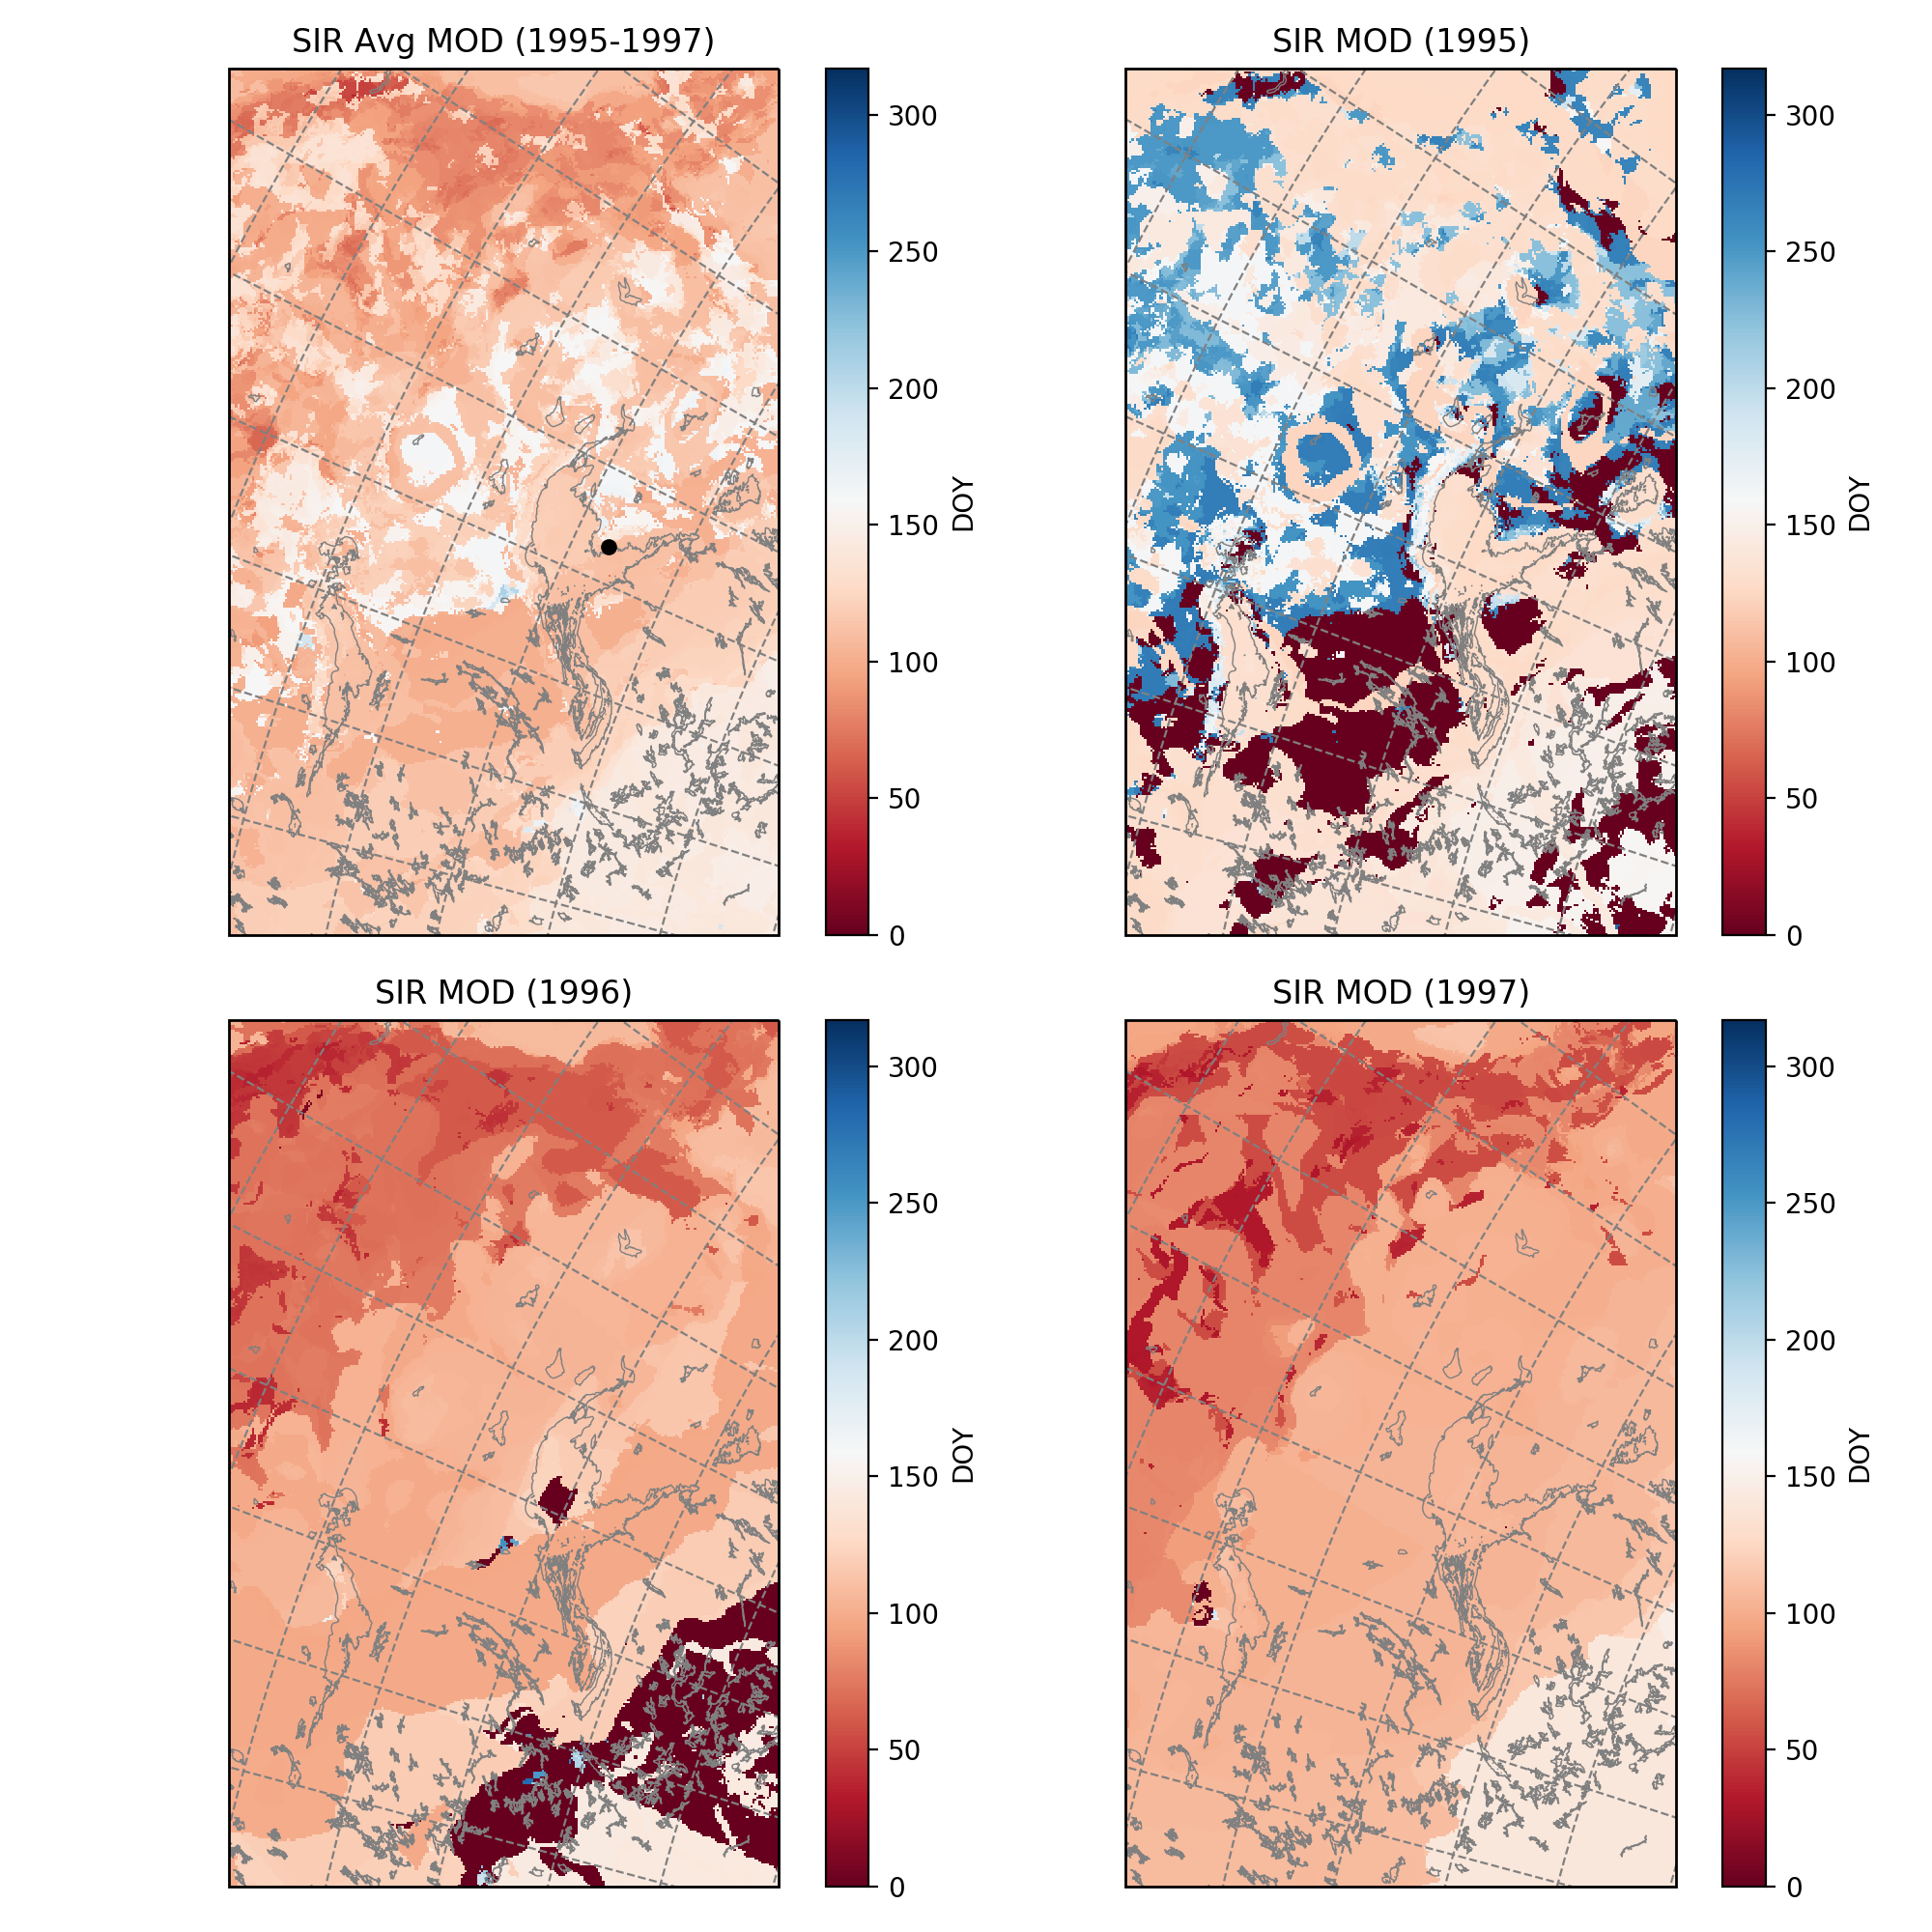

In [21]:
fig = plt.figure(figsize=(10,10))

# Placeholders for the various elements of each subplot
axes = []
images = []

numrows = 2
numcols = 2
numplots = 4

labels = ["SIR Avg MOD (%4d-%4d)" % (Years[0], Years[-1]),
          "SIR MOD (%d)" % Years[0],
          "SIR MOD (%d)" % Years[1],
          "SIR MOD (%d)" % Years[2]]

# Set the projection and extent for each subplot
for i in np.arange(numplots):
    axes.append(fig.add_subplot(numrows, numcols, i+1, projection=e2n))
    axes[i].set_extent(extent, crs=e2n)

images.append(axes[0].imshow(MODAVG['img'], 
              extent=extent, 
              transform=e2n,
              origin='upper', cmap='RdBu', 
              interpolation='None', vmin=mindoy, vmax=maxdoy, label=labels[0]))

images.append(axes[1].imshow(MOD1995['img'],
              extent=extent, 
              transform=e2n,
              origin='upper', cmap='RdBu', 
              interpolation='None', vmin=mindoy, vmax=maxdoy, label=labels[1]))

images.append(axes[2].imshow(MOD1996['img'],
              extent=extent,
              transform=e2n,
              origin='upper', cmap='RdBu', 
              interpolation='None', vmin=mindoy, vmax=maxdoy, label=labels[2]))

images.append(axes[3].imshow(MOD1997['img'],
              extent=extent, 
              transform=e2n,
              origin='upper', cmap='RdBu', 
              interpolation='None', vmin=mindoy, vmax=maxdoy, label=labels[3]))

# Identify the location we have for pixel closest to our lat, lon for Great Slave Lake
axes[0].plot(x, y, marker = '.', color='black', markersize=10)

# Do common display stuff for each subplot
for i in np.arange(numplots):
    axes[i].axis('off')
    axes[i].gridlines(color='gray', linestyle='--')
    axes[i].coastlines()
    axes[i].add_feature(wetlandFeatures, 
                        edgecolors='grey', facecolor='none', linewidth=0.5)
#    axes[i].add_geometries([e2nRotateHunzaBasin], e2nRotate,
#                      edgecolors='red', facecolor='none', lw=2)
    #For separate colorbars:
    cbar = fig.colorbar(images[i], ax=axes[i])
    cbar.ax.set_ylabel('DOY')
    axes[i].set_title(labels[i])

plt.tight_layout()
plt.show()
#fig.savefig("./test.SIR-avg-std-min-max.t%03d.png" % (bandnum-1), dpi=300)